# Solver and SLM Accuracy and Runtime Notebook

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
# import json


import sys
sys.path.append("./src")
from TOV_class import TOVsolver
from SLM import SLM
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()

In [3]:
error_threshold = 1e-6
modes = None  # set to `None` to auto-select modes 

EOS_modes = [13, 6, 9, 7, 9]
# EOS_modes = [None] * 5

In [4]:
# eos_path = "../EOS_Data/"
eos_path = "./../EOS_files/QEOS/"

# check the accuracy and runtimes with the tabular EOSs (5 of them)
# files_to_check = ["BL_eos.table", 
#                   "FSUGarnetNStarEOSA.txt", 
#                   "sorted_Sly4.dat", 
#                   "DS_CMF_eos.table", 
#                   "apr_eos.table"]
files_to_check = ["EOS_Quarkyonia_0.26_300.00.txt",
                  "EOS_Quarkyonia_0.12_352.63.txt",
                  "EOS_Quarkyonia_0.23_384.21.txt",
                  "EOS_Quarkyonia_0.14_436.84.txt",
                  "EOS_Quarkyonia_0.28_500.00.txt"]

# eos_names = ["BL", "FSU Garnet", "SLy4", "DSCMF", "APR"]
eos_names = ["300.00, 0.26", "352.63, 0.12", "384.21, 0.23", "436.84, 0.14", "500.00, 0.28"]

In [ ]:
sol_pts = 2500  # 5000  # number of points used per iteration for non solve_ivp solvers
number_of_solves = 1  # make this more for checking the runtimes !

# these empty lists will get filled with their corresponding runtimes per solve (size = `number_of_solves * 5`)
HF_runtimes = {"exact": [],
               "RK4": [],
               "RK2": [],
               "euler": []}
SLM_runtimes = {"exact": [],
                "RK4": [],
                "RK2": [],
                "euler": []}

## Calculate Exact (Adaptive) Solver

This uses `solve_ivp`

In [6]:
# tol = 3e-14

# # store the solutions per EOS
# exact_HF_results = {}
# exact_SLM_results = {}
# for i in np.arange(number_of_solves):
#     for i, file in enumerate(files_to_check):
#         eos_name = eos_names[i]
#         file_path = f"{eos_path}{file}"
#         # if not os.path.isfile(file_path):
#         #     print(f"\n\nSkipping {eos_name}: {file_path} not found.")
#         #     continue
#         print(f"\n\nChecking {eos_name}: ", end="")
        
#         # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
#         # "Radau" is particularly good for stick ODEs (like these). But RK45 should also be good too.
#         tov_exact = TOVsolver(file_path, tidal=True, solver="RK45", solve_ivp_kwargs={"method": "RK45", 
#                                                                                            "atol": tol, 
#                                                                                            "rtol": tol})
        
        
#         # time the HF solution
#         HF_start_time = time.time()
#         tov_exact.tov_routine(verbose=False, write_to_file=False)  # HF solution
#         HF_end_time = time.time()
#         HF_runtime = HF_end_time - HF_start_time
#         HF_runtimes["exact"].append(HF_runtime)
        
#         # store data
#         rad = tov_exact.total_radius
#         pres = tov_exact.total_pres_central
#         mass = tov_exact.total_mass
#         tidal = tov_exact.k2

#         X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)

#         linT = np.arange(len(pres))
#         dt = (linT[-1] - linT[0]) / len(linT)  # time step for SLM
#         print("dt:", dt)
#         # X_list = [np.log(r_orig), np.log(p_orig), np.log(m_orig)]
#         # if tidal is True:
#         #     X_list.append(np.log(tidal_def))
#         # X = np.asarray(X_list, dtype=np.float64)

#         SLM_start_time = time.time()
#         SLM_result = SLM(X, dt, error_threshold=error_threshold, modes=modes)
#         Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
#         SLM_end_time = time.time()
#         SLM_runtime = SLM_end_time - SLM_start_time
        
#         SLM_runtimes["exact"].append(SLM_runtime)

#         exact_HF_results[eos_name] = np.exp(X)
#         exact_SLM_results[eos_name] = np.exp(X_SLM)

#         print(f"HF solved in {HF_runtime:.4} seconds.")
#         print(f"SLM solved in {SLM_runtime:.4} seconds.")
#         print(f"speedup: {HF_runtime / SLM_runtime:.2}")


In [7]:
# fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

# ax[0].set_title("Visualizing Exact MR Curves")
# for eos in eos_names:
#     ax[0].scatter(exact_HF_results[eos][0], exact_HF_results[eos][2], 
#                 alpha=0.7, label=f"{eos} data")
#     ax[0].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][2], 
#              alpha=0.7, linewidth=3, label=f"{eos} SLM")
# ax[0].legend()


# ax[1].set_title("Visualizing Exact PR Curves")
# for eos in eos_names:
#     ax[1].scatter(exact_HF_results[eos][0], exact_HF_results[eos][1], 
#                 alpha=0.7, label=f"{eos} data")
#     ax[1].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][1], 
#              alpha=0.7, linewidth=3, label=f"{eos} SLM")
# ax[1].set_yscale("log")
# ax[1].legend()

# ax[2].set_title("Visualizing Exact k2R Curves")
# for eos in eos_names:
#     ax[2].scatter(exact_HF_results[eos][0], exact_HF_results[eos][3], 
#                 alpha=0.7, label=f"{eos} data")
#     ax[2].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][3], 
#              alpha=0.7, linewidth=3, label=f"{eos} SLM")
# ax[2].legend()

# plt.show()

## Check RK4 solver

In [8]:
EOS_modes[1]

6

In [9]:
# store the solutions per EOS
RK4_HF_results = {}
RK4_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK4 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK4", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK4.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK4"].append(HF_runtime)
        
        # store data
        rad = tov_RK4.total_radius
        pres = tov_RK4.total_pres_central
        mass = tov_RK4.total_mass
        tidal = tov_RK4.k2


        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        nan_indices = np.argwhere(np.isnan(X))
        if nan_indices.shape[0] > 0:
            nan_indices = nan_indices[:, 1]
            print("Filtered indices: ", end="")
            print(nan_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((X.shape[0], 
                                     X.shape[1] - len(nan_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(X.shape[1]):
                if j not in nan_indices:
                    filtered_data[:, qq] = X[:, j]
                    qq += 1
        else:
            filtered_data = X
        
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        SLM_result = SLM(filtered_data, dt, error_threshold=error_threshold, 
                         modes=EOS_modes[i])
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["RK4"].append(SLM_runtime)

        RK4_HF_results[eos_name] = np.exp(X)
        RK4_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking 300.00, 0.26: Woo it worked!
Max mass:  2.887066 Radius:  14.522147 Central pressure:  234.81381
HF solved in 11.72 seconds.
SLM solved in 0.000484 seconds.
speedup: 2.4e+04


Checking 352.63, 0.12: Woo it worked!


/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:299: RuntimeWarning: overflow encountered in scalar power
  dydx = -(1.0 / x) * (y**2.0 + f * y + q)
/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:299: RuntimeWarning: invalid value encountered in scalar add
  dydx = -(1.0 / x) * (y**2.0 + f * y + q)


Max mass:  2.665613 Radius:  12.60574 Central pressure:  393.310659
Filtered indices: [44]
HF solved in 11.42 seconds.
SLM solved in 0.0003603 seconds.
speedup: 3.2e+04


Checking 384.21, 0.23: Woo it worked!
Max mass:  2.476052 Radius:  11.520223 Central pressure:  584.698854
Filtered indices: [44]
HF solved in 11.32 seconds.
SLM solved in 0.0004191 seconds.
speedup: 2.7e+04


Checking 436.84, 0.14: Woo it worked!
Max mass:  2.328831 Radius:  10.66253 Central pressure:  810.174314
HF solved in 11.24 seconds.
SLM solved in 0.00037 seconds.
speedup: 3e+04


Checking 500.00, 0.28: Woo it worked!
Max mass:  2.223549 Radius:  10.166676 Central pressure:  1013.27043
HF solved in 11.22 seconds.
SLM solved in 0.0004649 seconds.
speedup: 2.4e+04


/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


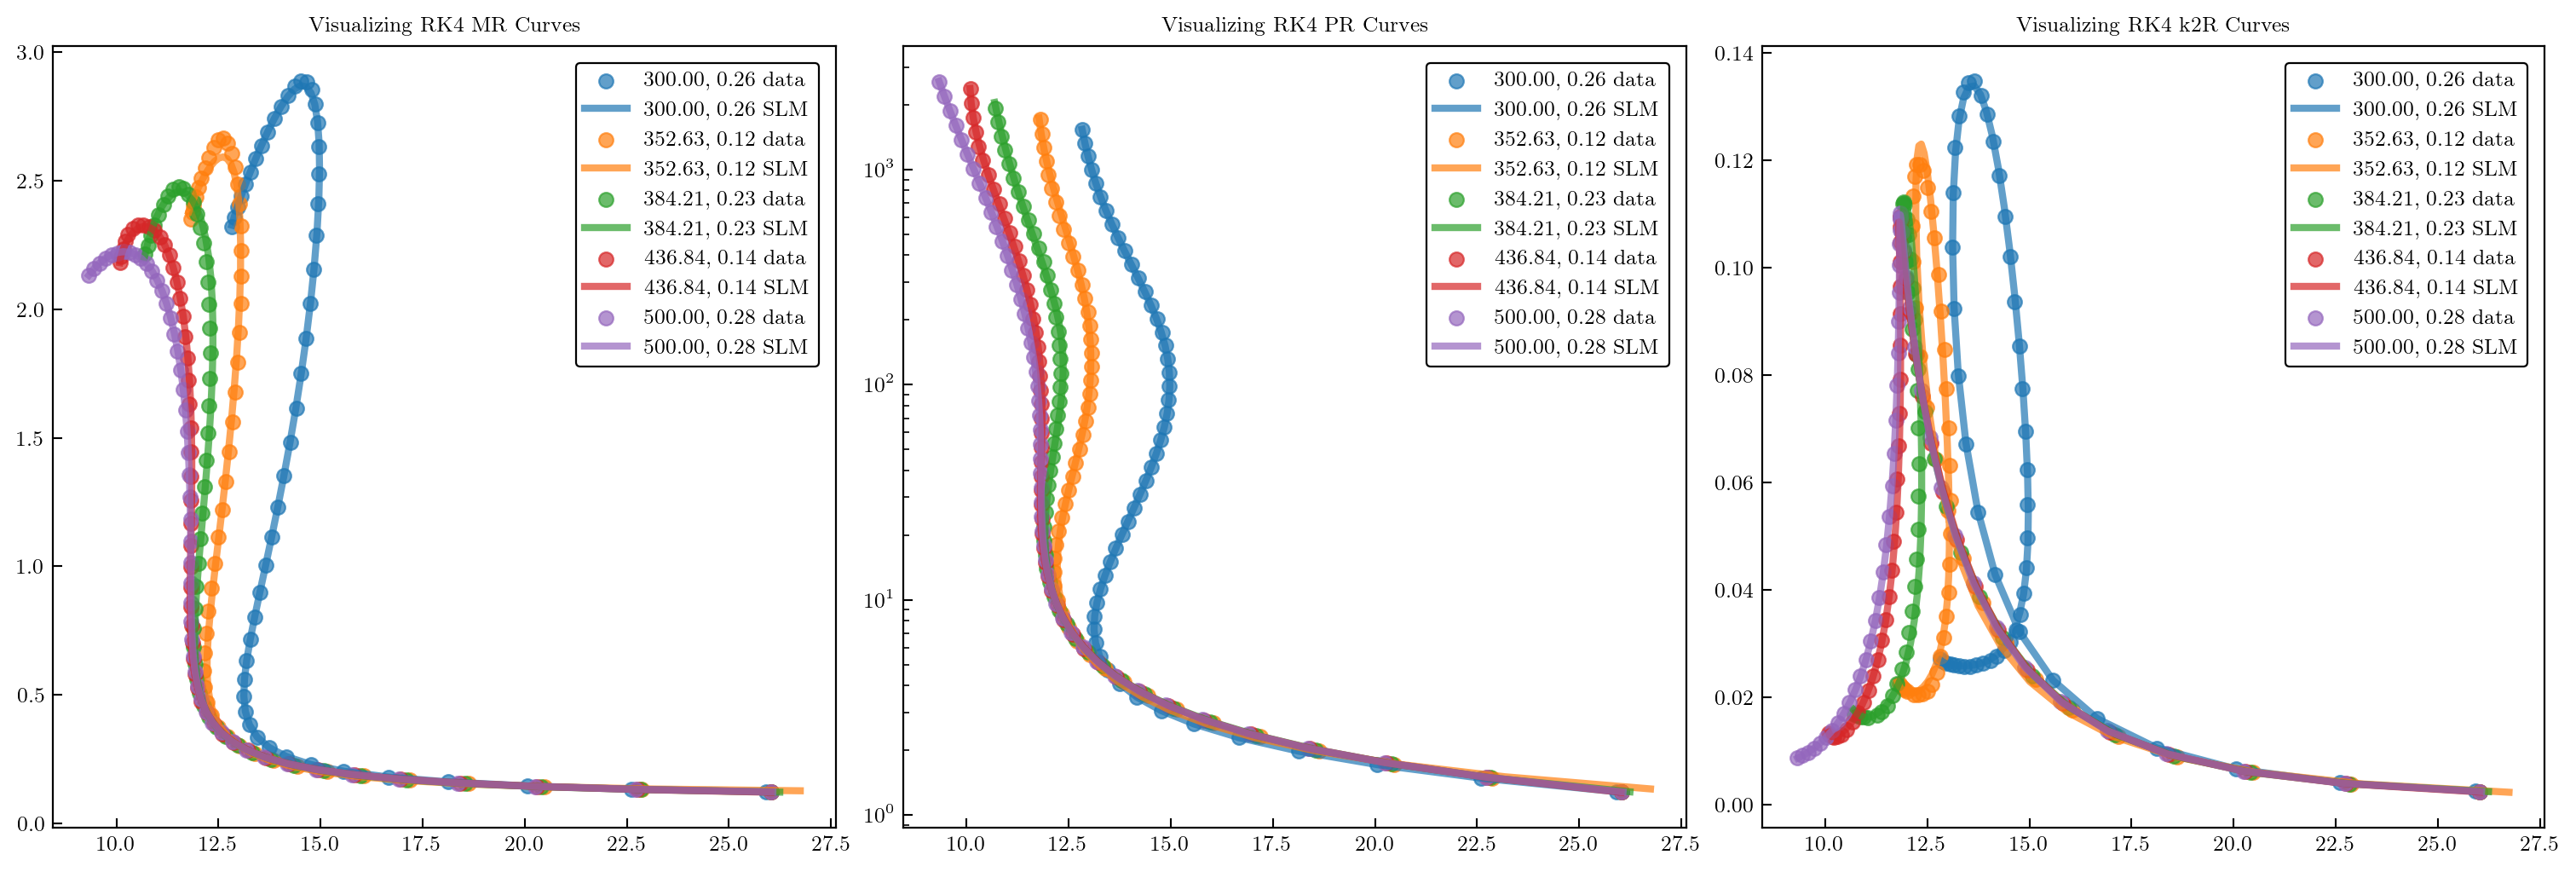

In [10]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK4 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK4 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing RK4 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK2 Solver

In [11]:
# store the solutions per EOS
RK2_HF_results = {}
RK2_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK2 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK2", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK2.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK2"].append(HF_runtime)
        
        # store data
        rad = tov_RK2.total_radius
        pres = tov_RK2.total_pres_central
        mass = tov_RK2.total_mass
        tidal = tov_RK2.k2

        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        nan_indices = np.argwhere(np.isnan(X))
        if nan_indices.shape[0] > 0:
            nan_indices = nan_indices[:, 1]
            print("Filtered indices: ", end="")
            print(nan_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((X.shape[0], 
                                     X.shape[1] - len(nan_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(X.shape[1]):
                if j not in nan_indices:
                    filtered_data[:, qq] = X[:, j]
                    qq += 1
        else:
            filtered_data = X
        
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        SLM_result = SLM(filtered_data, dt, error_threshold=error_threshold, 
                         modes=EOS_modes[i])
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        SLM_runtimes["RK2"].append(SLM_runtime)

        RK2_HF_results[eos_name] = np.exp(X)
        RK2_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking 300.00, 0.26: Woo it worked!
Max mass:  2.887071 Radius:  14.54895 Central pressure:  234.81381
HF solved in 5.721 seconds.
SLM solved in 0.0005109 seconds.
speedup: 1.1e+04


Checking 352.63, 0.12: Woo it worked!


/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:299: RuntimeWarning: overflow encountered in scalar power
  dydx = -(1.0 / x) * (y**2.0 + f * y + q)
/Users/joshuamaldonado/Documents/GitHub/SLM/src/TOV_class.py:299: RuntimeWarning: invalid value encountered in scalar add
  dydx = -(1.0 / x) * (y**2.0 + f * y + q)


Max mass:  2.665621 Radius:  12.645944 Central pressure:  393.310659
Filtered indices: [43 44]
HF solved in 5.649 seconds.
SLM solved in 0.0004039 seconds.
speedup: 1.4e+04


Checking 384.21, 0.23: Woo it worked!
Max mass:  2.47606 Radius:  11.547025 Central pressure:  584.698854
Filtered indices: [48]
HF solved in 5.635 seconds.
SLM solved in 0.0004759 seconds.
speedup: 1.2e+04


Checking 436.84, 0.14: Woo it worked!


/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_31508/3190479079.py:55: RuntimeWarning: overflow encountered in exp
  RK2_SLM_results[eos_name] = np.exp(X_SLM)


Max mass:  2.32884 Radius:  10.702734 Central pressure:  810.174314
HF solved in 5.715 seconds.
SLM solved in 0.000387 seconds.
speedup: 1.5e+04


Checking 500.00, 0.28: Woo it worked!
Max mass:  2.223559 Radius:  10.206881 Central pressure:  1013.27043
HF solved in 5.616 seconds.
SLM solved in 0.0004189 seconds.
speedup: 1.3e+04


In [12]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK2 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK2 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing RK2 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/ticker.py:2468: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


OverflowError: cannot convert float infinity to integer

<Figure size 3000x1000 with 3 Axes>

# Check Euler Solver

In [13]:
# store the solutions per EOS
euler_HF_results = {}
euler_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_euler = TOVsolver(f"{eos_path}{file}", tidal=True, solver="euler", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_euler.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["euler"].append(HF_runtime)
        
        # store data
        rad = tov_euler.total_radius
        pres = tov_euler.total_pres_central
        mass = tov_euler.total_mass
        tidal = tov_euler.k2

        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        nan_indices = np.argwhere(np.isnan(X))
        if nan_indices.shape[0] > 0:
            nan_indices = nan_indices[:, 1]
            print("Filtered indices: ", end="")
            print(nan_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((X.shape[0], 
                                     X.shape[1] - len(nan_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(X.shape[1]):
                if j not in nan_indices:
                    filtered_data[:, qq] = X[:, j]
                    qq += 1
        else:
            filtered_data = X
        
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        SLM_result = SLM(filtered_data, dt, error_threshold=error_threshold, 
                         modes=EOS_modes[i])
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["euler"].append(SLM_runtime)
        
        euler_HF_results[eos_name] = np.exp(X)
        euler_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking 300.00, 0.26: Woo it worked!
Max mass:  2.887562 Radius:  14.428337 Central pressure:  234.81381
HF solved in 2.829 seconds.
SLM solved in 0.0004361 seconds.
speedup: 6.5e+03


Checking 352.63, 0.12: Woo it worked!
Max mass:  2.666127 Radius:  12.51193 Central pressure:  393.310659
Filtered indices: [43 48]
HF solved in 2.824 seconds.
SLM solved in 0.000427 seconds.
speedup: 6.6e+03


Checking 384.21, 0.23: Woo it worked!
Max mass:  2.475937 Radius:  11.413011 Central pressure:  584.698854
Filtered indices: [49]
HF solved in 2.809 seconds.
SLM solved in 0.000365 seconds.
speedup: 7.7e+03


Checking 436.84, 0.14: Woo it worked!
Max mass:  2.328324 Radius:  10.515114 Central pressure:  810.174314
Filtered indices: [47]
HF solved in 2.818 seconds.
SLM solved in 0.0003679 seconds.
speedup: 7.7e+03


Checking 500.00, 0.28: Woo it worked!
Max mass:  2.222609 Radius:  10.059465 Central pressure:  1013.27043
HF solved in 2.767 seconds.
SLM solved in 0.0004148 seconds.
speedup: 6.7e+

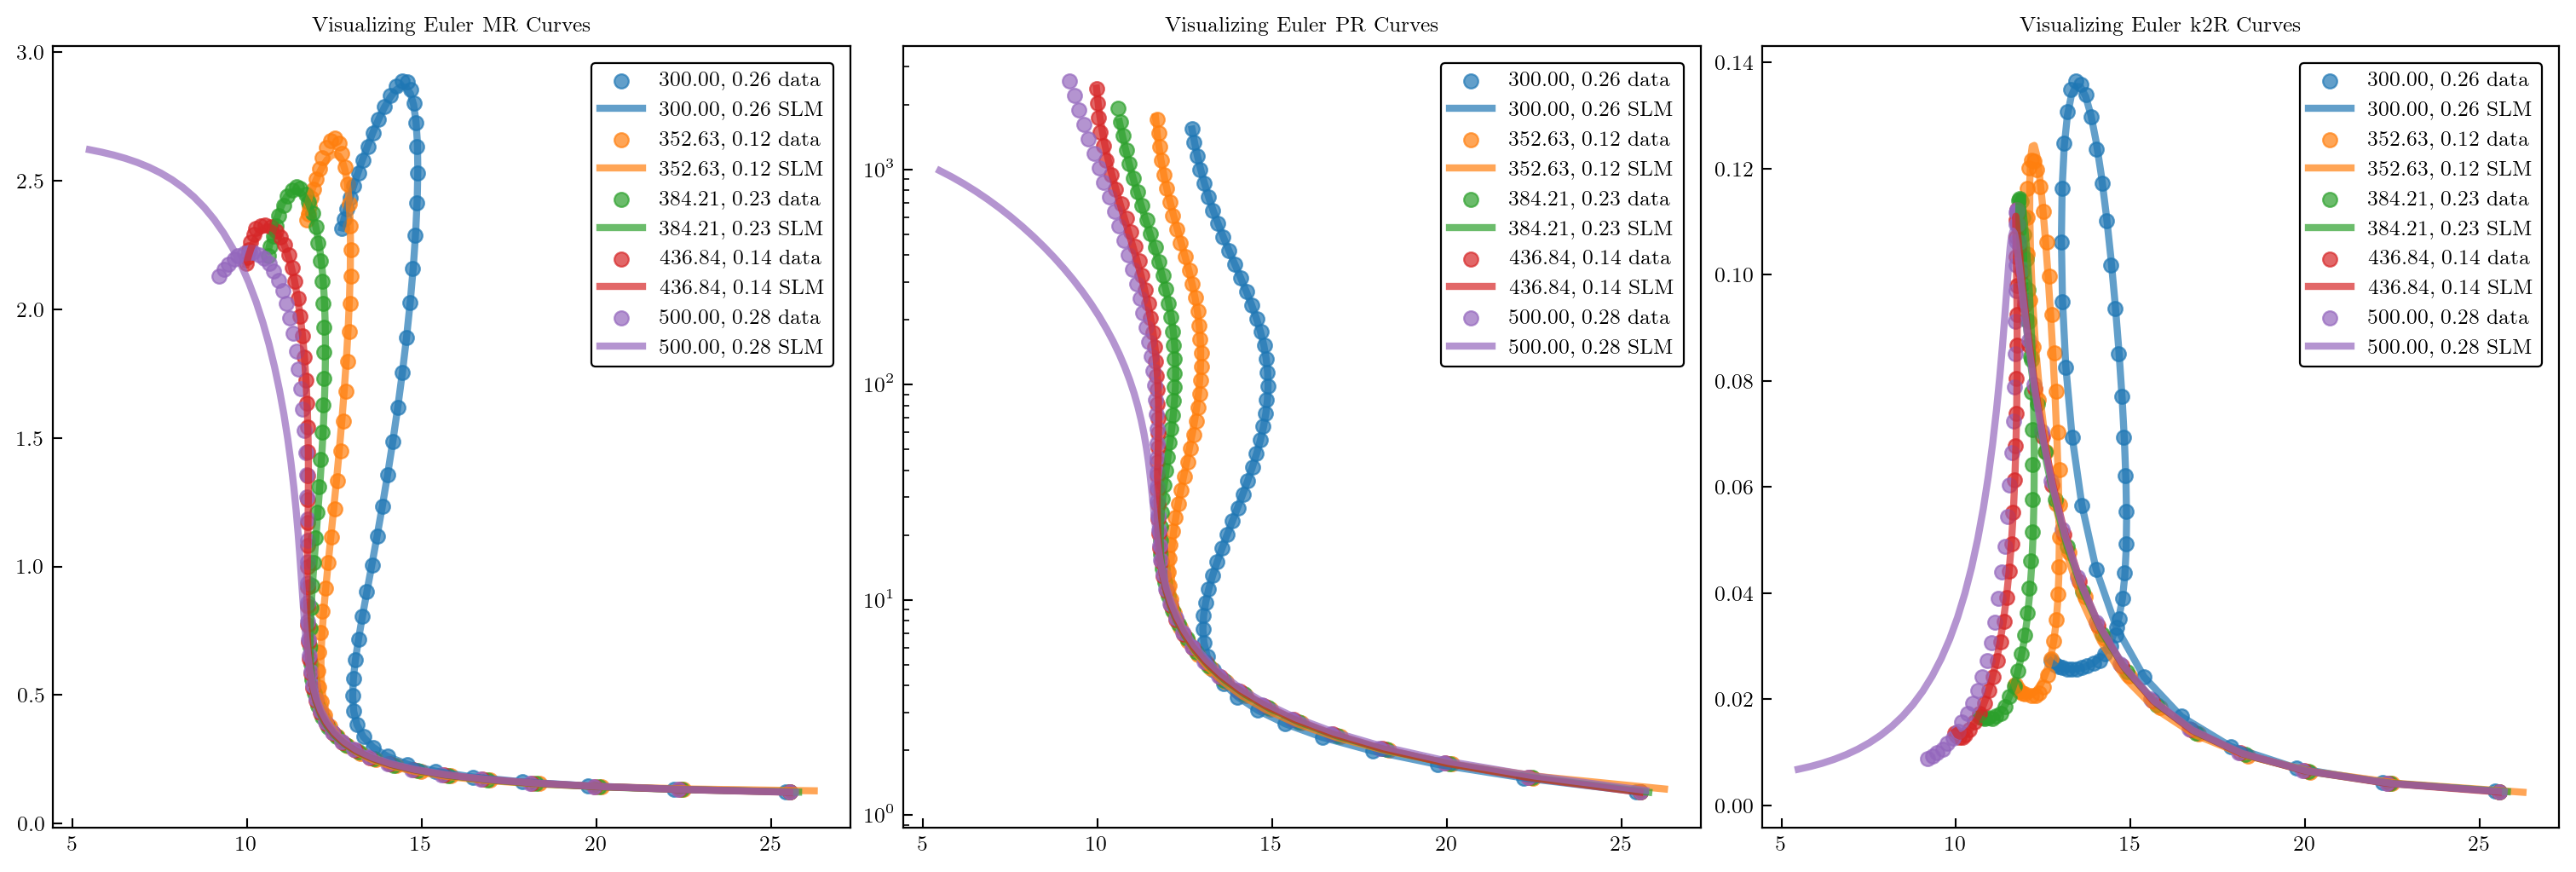

In [14]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Euler MR Curves")
for eos in eos_names:
    ax[0].scatter(euler_HF_results[eos][0], euler_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Euler PR Curves")
for eos in eos_names:
    ax[1].scatter(euler_HF_results[eos][0], euler_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing Euler k2R Curves")
for eos in eos_names:
    ax[2].scatter(euler_HF_results[eos][0], euler_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Nice! Now look at errors

I'm not totally sure the best way to go about this. So I'll look at where the peak is on the MR curve since that's how we did the errors on the table originally.

In [15]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

def percent_error(HF, SLM):
    try:
        error = 100 * np.abs(HF - SLM) / HF
    except:
        error = np.nan
    return error

In [16]:
HF_runtimes

{'exact': [],
 'RK4': [11.71759819984436,
  11.42118215560913,
  11.322604179382324,
  11.23822021484375,
  11.22476077079773],
 'RK2': [5.720757007598877,
  5.648684024810791,
  5.634781837463379,
  5.715204954147339,
  5.615796327590942],
 'euler': [2.8287229537963867,
  2.8239779472351074,
  2.809436321258545,
  2.818272113800049,
  2.7667031288146973]}

In [17]:
errors = {}  # for storing all errors
exact_HF = []  # for comparing HF solvers to the exact results

rad_HF = {}
mass_HF = {}
rad_SLM = {}
mass_SLM = {}

solvers = ["RK4", "RK2", "euler"]
for solver in solvers:
    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        HF = eval(f"{solver}_HF_results[\"{eos_name}\"]")
        SLM_data = eval(f"{solver}_SLM_results[\"{eos_name}\"]")
        
        # select max point on MR curve
        # for HF
        HF_max_index = np.where(HF[2] == np.max(HF[2]))[0][0]  # grab index the maximum mass
        HF_max_rad = HF[0][HF_max_index]
        HF_max_mass = HF[2][HF_max_index]
        rad_HF[f"{eos_name} {solver}"] = HF_max_rad
        mass_HF[f"{eos_name} {solver}"] = HF_max_mass
        # for SLM
        SLM_max_index = np.where(SLM_data[2] == np.max(SLM_data[2]))[0][0]  # grab index the maximum mass
        SLM_max_rad = SLM_data[0][SLM_max_index].real
        SLM_max_mass = SLM_data[2][SLM_max_index].real
        rad_SLM[f"{eos_name} {solver}"] = SLM_max_rad
        mass_SLM[f"{eos_name} {solver}"] = SLM_max_mass
        
        # store the exact results for comparing to the other solvers
        # if (solver == "exact"):
        #     exact_HF.append([HF_max_rad, HF_max_mass])
        # else:
        #     errors[f"{eos_name} {solver} HF rad"] = percent_error(exact_HF[i][0], HF_max_rad)
        #     errors[f"{eos_name} {solver} HF mass"] = percent_error(exact_HF[i][1], HF_max_mass)
        
        # compare SLM to it's corresponding HF solver
        errors[f"{eos_name} {solver} SLM rad"] = percent_error(HF_max_rad, SLM_max_rad)
        errors[f"{eos_name} {solver} SLM mass"] = percent_error(HF_max_mass, SLM_max_mass)


# print results
for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    print(f"{eos_name} EOS:                 <----")
    for solver in solvers:
        if solver == "RK4":
            print("!!!")
        if (solver != "exact"):
            print(f"{solver} HF result: ")
            print(f"      mass = {np.round(mass_HF[f"{eos_name} {solver}"], 3)}")
            print(f"    radius = {np.round(rad_HF[f"{eos_name} {solver}"], 3)}")
            print(f"{solver} SLM result: ")
            print(f"      mass = {np.round(mass_SLM[f"{eos_name} {solver}"], 3)}")
            print(f"    radius = {np.round(rad_SLM[f"{eos_name} {solver}"], 3)}")
            
            # print(f"{solver} HF  error:")
            # print(f"    mass={np.round(errors[f"{eos_name} {solver} HF mass"], 2)}")
            # print(f"    rad={np.round(errors[f"{eos_name} {solver} HF rad"], 2)}")
            print(f"{solver} SLM error:")
            print(f"    mass={np.round(errors[f"{eos_name} {solver} SLM mass"], 2)}")
            print(f"    rad={np.round(errors[f"{eos_name} {solver} SLM rad"], 2)}")
        else:
            print(f"{solver} SLM error:")
            print(f"    mass = {np.round(errors[f"{eos_name} {solver} SLM mass"], 2)}")
            print(f"    rad = {np.round(errors[f"{eos_name} {solver} SLM rad"], 2)}")
        
        print(f"HF runtime = {np.round(HF_runtimes[solver][i], 3)}s")
        print(f"SLM runtime = {np.round(1e4 * SLM_runtimes[solver][i], 3)} x 1e4s")
        print("")
    print("")


300.00, 0.26 EOS:                 <----
!!!
RK4 HF result: 
      mass = 2.887
    radius = 14.522
RK4 SLM result: 
      mass = 2.87
    radius = 14.51
RK4 SLM error:
    mass=0.6
    rad=0.08
HF runtime = 11.718s
SLM runtime = 4.84 x 1e4s

RK2 HF result: 
      mass = 2.887
    radius = 14.549
RK2 SLM result: 
      mass = 2.869
    radius = 14.538
RK2 SLM error:
    mass=0.61
    rad=0.08
HF runtime = 5.721s
SLM runtime = 5.109 x 1e4s

euler HF result: 
      mass = 2.888
    radius = 14.428
euler SLM result: 
      mass = 2.867
    radius = 14.412
euler SLM error:
    mass=0.7
    rad=0.11
HF runtime = 2.829s
SLM runtime = 4.361 x 1e4s


352.63, 0.12 EOS:                 <----
!!!
RK4 HF result: 
      mass = 2.666
    radius = 12.606
RK4 SLM result: 
      mass = 2.593
    radius = 12.615
RK4 SLM error:
    mass=2.74
    rad=0.07
HF runtime = 11.421s
SLM runtime = 3.603 x 1e4s

RK2 HF result: 
      mass = 2.666
    radius = 12.646
RK2 SLM result: 
      mass = 2.565
    radius = 

In [18]:
print(f"{11 / (3e-4):.3e}")
print(f"{11 / (5e-4):.3e}")
print(f"{11 / (2e-4):.3e}")
print(f"{11 / (1e-4):.3e}")

3.667e+04
2.200e+04
5.500e+04
1.100e+05


## Cat Plot !


```
 _._     _,-'""`-._        
(,-.`._,'(       |\`-/|    
    `-.-' \ )-`( , o o)    
          `-    \`_`"'-    
```

KeyError: '300.00, 0.26 RK4 HF mass'

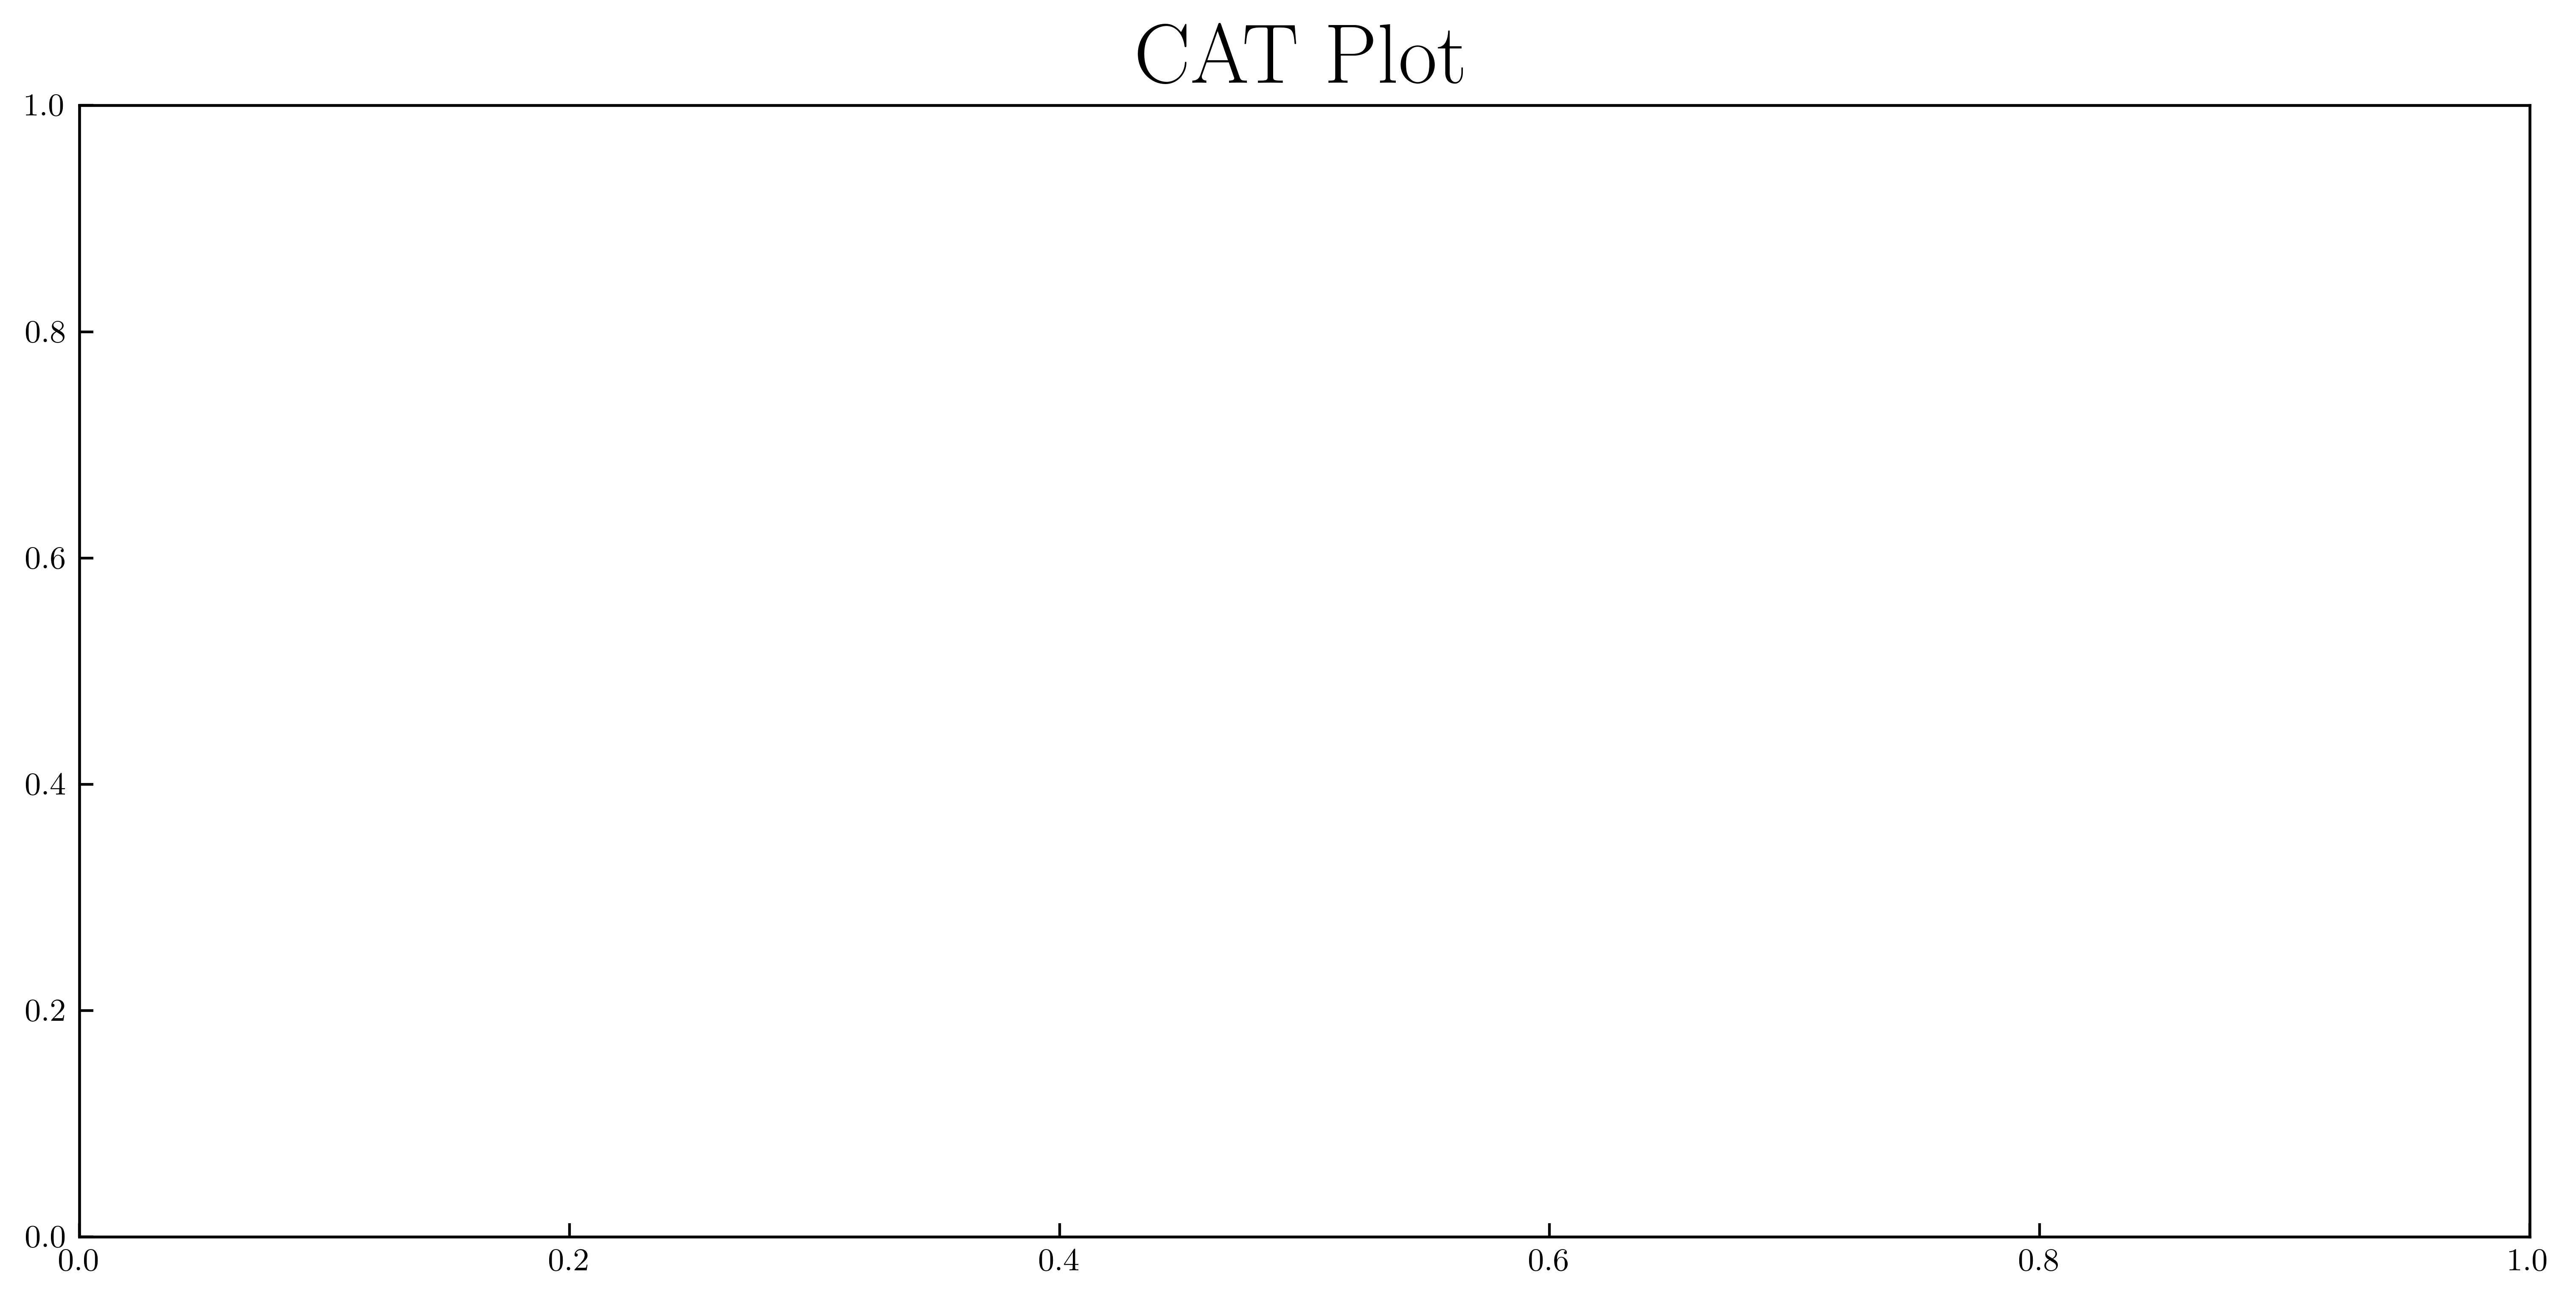

In [19]:
from matplotlib.patches import Ellipse
from matplotlib.transforms import ScaledTranslation


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
markers = ["d", "^", "*", "o"]
sizes = [80] * 2  # [75, 25]

alpha = 0.8

SLM_timings = []
SLM_accuracy = []


fig, ax = plt.subplots(1, 1, dpi=600, figsize=(10, 5))
ax.set_title("CAT Plot", fontsize=24)

for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    for j, solver in enumerate(solvers):
        SLM_error = errors[f"{eos_name} {solver} SLM mass"]
        
        SLM_timings.append(SLM_runtimes[solver][i])
        SLM_accuracy.append(errors[f"{eos_name} {solver} SLM mass"])
        
        if (solver != "exact"):
            HF_error = errors[f"{eos_name} {solver} HF mass"]
            
            ax.scatter(HF_runtimes[solver][i], 
                       HF_error, 
                       marker=markers[j],
                       color=colors[i],
                       s=sizes[0], 
                       alpha=alpha,
                       # label=f"{eos_name} {solver.capitalize() if solver == "euler" else solver.upper()}"
                       )
            # ax.scatter(SLM_runtimes[solver][i], 
            #            SLM_error, 
            #            marker=markers[j],
            #            color=colors[i], 
            #            s=sizes[1],
            #            alpha=alpha)#, label=f"{eos_name} SLM")
        else:
            ax.scatter(SLM_runtimes[solver][i], 
                       SLM_error, 
                       marker=markers[j],
                       color=colors[i], 
                       s=sizes[1],
                       alpha=alpha, 
                       # label=f"{eos_name} SLM"
                       )
        
        if i == 0:
            if solver != "exact":
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="grey", marker=markers[j], label=f"{solver.capitalize() if solver == "euler" else solver.upper()}")
            else:
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="white", marker=markers[j], label=f" ")
    print(eos_name)
    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[i], marker="s", label=f"{eos_name}")
# ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[0], marker="s", label=f"Exact")
#

ax.annotate("Exact", (np.mean(HF_runtimes["exact"]) - 14, 3.0 * 1e-1), fontsize=16)
ax.axvline(np.mean(HF_runtimes["exact"]),
           alpha=alpha, color="black", linewidth=3)#, label=f"{eos_name} {solver.capitalize()}")



ax.annotate("SLM Results", (3.0 * 1e-3, 1.8 * 1e-1), fontsize=16)
# Ellipse centre coordinates
x, y = (np.mean(SLM_timings), np.mean(SLM_accuracy))
# x -= 0 * 1e-4
y -= 0.083
# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
ellipse_1 = Ellipse((x, y), 0.42, 4.7,  color="grey", fill=True, alpha=0.3, linewidth=2, transform=ell_tform)
ellipse_2 = Ellipse((x, y), 0.42, 4.7,  color="black", fill=False, alpha=0.9, linewidth=2, transform=ell_tform)
ax.add_patch(ellipse_1)
ax.add_patch(ellipse_2)



ax.set_xlabel("Time [Seconds]",               fontsize=16)
ax.set_ylabel("Relative Error in Max Mass [---]", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

handles, labels = plt.gca().get_legend_handles_labels()
# order = [4, 5, 6, 7, 8, 0, 1, 2, 3]  # label EOSs first, then solvers
# order = [4, 0, 5, 1, 6, 2, 7, 3, 8]
order = [0, 4, 1, 5, 2, 6, 3, 7, 0, 8]
ax.legend([handles[i] for i in order], [labels[i] for i in order], 
          loc="lower center", ncols=5, framealpha=0., fontsize=11, bbox_to_anchor=(0.5, -0.025))
plt.tight_layout()
plt.savefig("./../Plots/CAT-rad.pdf")
plt.show()


In [ ]:
from matplotlib.patches import Ellipse
from matplotlib.transforms import ScaledTranslation


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
markers = ["d", "^", "*", "o"]
sizes = [80] * 2  # [75, 25]

alpha = 0.8

SLM_timings = []
SLM_accuracy = []


fig, ax = plt.subplots(1, 1, dpi=600, figsize=(10, 5))
ax.set_title("CAT Plot", fontsize=24)

for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    for j, solver in enumerate(solvers):
        SLM_error = errors[f"{eos_name} {solver} SLM rad"]
        
        SLM_timings.append(SLM_runtimes[solver][i])
        SLM_accuracy.append(errors[f"{eos_name} {solver} SLM rad"])
        
        if (solver != "exact"):
            HF_error = errors[f"{eos_name} {solver} HF rad"]
            
            ax.scatter(HF_runtimes[solver][i], 
                       HF_error, 
                       marker=markers[j],
                       color=colors[i],
                       s=sizes[0], 
                       alpha=alpha,
                       # label=f"{eos_name} {solver.capitalize() if solver == "euler" else solver.upper()}"
                       )
            # ax.scatter(SLM_runtimes[solver][i], 
            #            SLM_error, 
            #            marker=markers[j],
            #            color=colors[i], 
            #            s=sizes[1],
            #            alpha=alpha)#, label=f"{eos_name} SLM")
        else:
            ax.scatter(SLM_runtimes[solver][i], 
                       SLM_error, 
                       marker=markers[j],
                       color=colors[i], 
                       s=sizes[1],
                       alpha=alpha, 
                       # label=f"{eos_name} SLM"
                       )
        
        if i == 0:
            if solver != "exact":
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="grey", marker=markers[j], label=f"{solver.capitalize() if solver == "euler" else solver.upper()}")
            else:
                ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="white", marker=markers[j], label=f" ")
    print(eos_name)
    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[i], marker="s", label=f"{eos_name}")
# ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[0], marker="s", label=f"Exact")
#

ax.annotate("Exact", (np.mean(HF_runtimes["exact"]) - 14, 3.0 * 1e-1), fontsize=16)
ax.axvline(np.mean(HF_runtimes["exact"]),
           alpha=alpha, color="black", linewidth=3)#, label=f"{eos_name} {solver.capitalize()}")



ax.annotate("SLM Results", (3.1 * 1e-3, 1.9 * 1e-1), fontsize=16)
# Ellipse centre coordinates
x, y = (np.mean(SLM_timings), np.mean(SLM_accuracy))
x -= 1 * 1e-4
y -= 0.048
# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, ax.transScale)
# construct the composite tform
ell_tform = ell_offset + ax.transLimits + ax.transAxes
ellipse_1 = Ellipse((x, y), 0.42, 3.1,  color="grey", fill=True, alpha=0.3, linewidth=2, transform=ell_tform)
ellipse_2 = Ellipse((x, y), 0.42, 3.1,  color="black", fill=False, alpha=0.9, linewidth=2, transform=ell_tform)
ax.add_patch(ellipse_1)
ax.add_patch(ellipse_2)



ax.set_xlabel("Time [Seconds]",                     fontsize=16)
ax.set_ylabel("Relative Error in Max Radius [---]", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

handles, labels = plt.gca().get_legend_handles_labels()
# order = [4, 5, 6, 7, 8, 0, 1, 2, 3]  # label EOSs first, then solvers
# order = [4, 0, 5, 1, 6, 2, 7, 3, 8]
order = [0, 4, 1, 5, 2, 6, 3, 7, 0, 8]
ax.legend([handles[i] for i in order], [labels[i] for i in order], 
          loc="lower center", ncols=5, framealpha=0., fontsize=11, bbox_to_anchor=(0.5, -0.025))

plt.tight_layout()
plt.savefig("./../Plots/CAT-mass.pdf")
plt.show()


In [20]:
np.mean(list(HF_runtimes.values())) / np.mean(list(SLM_runtimes.values()))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.